# GPU-based parallel parameter sweeps

A frequent bottleneck in TVB-based studies are the parameter sweeps that allow a TVB user to characterize the sensitivity of a TVB model to key parameters such as a conduction velocity and coupling strength.  Because the sequence of simulations are parallel and independant, they are amenable to parallelization using general purpose graphics processing units (GPUs) which are now frequently found in HPC centers.

## Quickstart

To assist with a user running on a HPC site via Slurm or similar job scheduler, a helpful command line interface is provided,

In [1]:
!python -m tvb.dsl_cuda.run --help

2020-09-11 13:22:53,114 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
/home/maedoc/src/tvb-root/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
usage: __main__.py [-h] [-c N_COUPLING] [-s N_SPEED] [-t] [-n N_TIME] [-v]
                   [--node_threads NODE_THREADS]
                   [--model {Rwongwang,Kuramoto,Epileptor,Oscillator,Oscillatorref,Kuramotoref,Rwongwangref,Epileptorref}]
                   [--lineinfo] [--filename FILENAME] [-b BENCH]
                   [-bx BLOCKSZX] [-by BLOCKSZY] [-val VALIDATE]

Run parameter sweep.

optional arguments:
  -h, --help            show this help message and exit
  -c N_COUPLING, --n_coupling N_COUPLING
                        num grid points for coupling parameter
  -s N_SPE

This allows for configuring and running a parameter sweep in single command,

In [4]:
!python -m tvb.dsl_cuda.run --model Rwongwang -n 40 -c 64 -s 64

2020-09-11 13:25:33,377 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
/home/maedoc/src/tvb-root/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
/home/maedoc/src/tvb-root/scientific_library/tvb/dsl_cuda/run/cuda_run.py:28: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(67): warning: variable "global_speed" was declared but never referenced

kernel.cu(68): warning: variable "global_coupling" was declared but never referenced

kernel.cu(91): warning: variable "J_N" was declared but never referenced

kernel.cu(92): warning: variable "J_I" was declared but never referenced



This demonstrates a 64x64 sweep completed in 3s on a Nvidia RTX5000 GPU. 

## Detailed usage

More extensive integration and output analysis in the notebook is possible by making direct use of the API exposed in the dsl_cuda module. 

We start with a few imports and set up,

In [8]:
import numpy as np
import pycuda.autoinit
import itertools
import argparse
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator import coupling, integrators
import tvb.dsl_cuda
from tvb.dsl_cuda import LEMS2CUDA
from tvb.dsl_cuda.run.cuda_run import CudaRun
import os
import logging
import tqdm
logger = logging.getLogger('[gpu_demo]')
cu_models_path = os.path.join(os.path.dirname(tvb.dsl_cuda.__file__), 'CUDAmodels')

as the internal structure of the GPU support is oriented around the CLI we'll reproduce the argument parser here

In [9]:
parser = argparse.ArgumentParser()
parser.add_argument('-c', '--n_coupling', help='num grid points for coupling parameter', default=32, type=int)
parser.add_argument('-s', '--n_speed', help='num grid points for speed parameter', default=32, type=int)
parser.add_argument('-t', '--test', help='check results', action='store_true')
parser.add_argument('-n', '--n_time', help='number of time steps to do (default 400)', type=int, default=400)
parser.add_argument('-v', '--verbose', help='increase logging verbosity', action='store_true', default='-v')
parser.add_argument('--node_threads', default=1, type=int)
parser.add_argument('--model',
                    choices=['Rwongwang', 'Kuramoto', 'Epileptor', 'Oscillator', \
                             'Oscillatorref', 'Kuramotoref', 'Rwongwangref', 'Epileptorref'],
                    help="neural mass model to be used during the simulation",
                    default='Oscillator'
                    )
parser.add_argument('--lineinfo', default=True, action='store_true')

parser.add_argument('--filename', default="kuramoto_network.c", type=str,
                    help="Filename to use as GPU kernel definition")

parser.add_argument('-b', '--bench', default="regular", type=str, help="What to bench: regular, numba, cuda")

parser.add_argument('-bx', '--blockszx', default="32", type=int, help="Enter block size x")
parser.add_argument('-by', '--blockszy', default="32", type=int, help="Enter block size y")

parser.add_argument('-val', '--validate', default=False, help="Enable validation to refmodels")

_StoreAction(option_strings=['-val', '--validate'], dest='validate', nargs=None, const=None, default=False, type=None, choices=None, help='Enable validation to refmodels', metavar=None)

which then allows us to then create the configuration easily, in a single line,

In [10]:
args = parser.parse_args('-c 32 -s 32 --model Kuramoto'.split(' '))
args

Namespace(bench='regular', blockszx=32, blockszy=32, filename='kuramoto_network.c', lineinfo=True, model='Kuramoto', n_coupling=32, n_speed=32, n_time=400, node_threads=1, test=False, validate=False, verbose='-v')

As in TVB, we construct a connectivity and coupling function,

In [11]:
connectivity = Connectivity.from_file(source_file="connectivity_68.zip")
connectivity.configure()
speed = np.array([3.0])
coupling = coupling.Linear(a=np.array([0.1]))

2020-09-11 14:58:18,514 - WARNING - tvb.basic.readers - File 'cortical' not found in ZIP.
2020-09-11 14:58:18,516 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2020-09-11 14:58:18,516 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


We specify a grid of parameter values to sweep,

In [12]:
couplings = np.logspace(1.6, 3.0, args.n_coupling)
speeds = np.logspace(0.0, 2.0, args.n_speed)
params_iter = itertools.product(speeds, couplings)
params = np.array([vals for vals in params_iter], np.float32)

set up the rest of the simulator details,

In [13]:
g = np.array([1.0])
s = np.array([1.0])
dt = 0.1
period = 10.0
omega = 60.0 * 2.0 * np.pi / 1e3
integrator = integrators.EulerDeterministic(dt=dt)
weights = SC = connectivity.weights
lengths = connectivity.tract_lengths
n_nodes = weights.shape[0]
tavg_period = 10.0
nstep = args.n_time
n_inner_steps = int(tavg_period / dt)
n_work_items, n_params = params.shape
min_speed = speeds.min()
buf_len_ = ((lengths / min_speed / dt).astype('i').max() + 1)
buf_len = 2 ** np.argwhere(2 ** np.r_[:30] > buf_len_)[0][0]  # use next power of 2
states = 1

and then run the parameter sweep

In [17]:
args.filename = cu_models_path + f'/{args.model.lower()}.c'
states = 1
runner = CudaRun()
tavg_data = runner.run_simulation(
    weights, lengths, params, speeds, logger,
    args, n_nodes, n_work_items, n_params, nstep,
    n_inner_steps, buf_len, states, dt, min_speed)

/home/maedoc/src/tvb-root/scientific_library/tvb/dsl_cuda/run/cuda_run.py:28: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas info    : 64448 bytes gmem, 96 bytes cmem[3]
ptxas info    : Compiling entry function '_Z8KuramotojjjjjffPfS_S_S_S_' for 'sm_75'
ptxas info    : Function properties for _Z8KuramotojjjjjffPfS_S_S_S_
    32 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 32 registers, 424 bytes cmem[0], 16 bytes cmem[2]

  network_module = SourceModule(
100%|██████████| 400/400 [00:37<00:00, 10.58it/s]


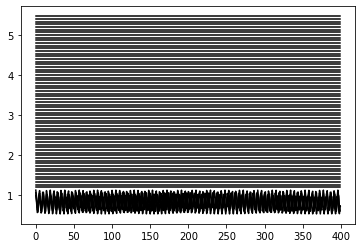

In [43]:
plot(cos(tavg_data[..., 0]) + np.r_[:68]/15.0, 'k');

With the temporal average at 10 Hz in hand, we can now do some post processing, such as computing the functional connectivities,

In [25]:
cc = np.zeros((1024, 68, 68), 'f')
for i in tqdm.trange(1024):
    cc[i] = np.corrcoef(tavg_data[..., 0].T)

100%|██████████| 1024/1024 [00:00<00:00, 1957.60it/s]


and then compute an L2 norm with the structural connectivity, 

In [29]:
l2 = np.sqrt(np.sum(np.sum((cc - weights)**2, axis=-1), axis=-1)).reshape((32, 32))

and then visualize it,

Populating the interactive namespace from numpy and matplotlib


/home/maedoc/miniconda3/envs/tvb-dsl-cuda/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/maedoc/miniconda3/envs/tvb-dsl-cuda/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/maedoc/miniconda3/envs/tvb-dsl-cuda/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/maedoc/miniconda3/envs/tvb-dsl-cuda/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


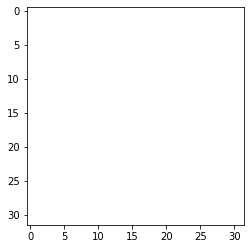

In [31]:
%pylab inline
imshow(l2)

Here the is an issue with the choice of parameters causing NaNs.